# A big 10x data set, August 2022

# Loading packages, etc.

In [2]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
file_prefix = 'Processed/'
file_suffix = '.loom' 
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Sample identification ("wells")

Each cell (barcoded in a single droplet) was in a larger pool (Samples 1-6).  We figure out the sample number here, and call it the "well".

In [4]:
filename_barcode = '20220815_JM_10x_1_CHfiltered_CH_matrix.csv'
barcode_df = pd.read_csv(filename_barcode, index_col = 0)
barcode_df.columns = [cell.replace('.','-') for cell in barcode_df.columns] # Change dot to dash.
display(barcode_df)

,AAACCTGAGAAGGTGA-1,AAACCTGAGACAGGCT-1,AAACCTGAGCCCAATT-1,AAACCTGAGGACAGAA-1,AAACCTGCAGACACTT-1,AAACCTGCAGTATGCT-1,AAACCTGCATAGACTC-1,AAACCTGCATTGGCGC-1,AAACCTGGTACGCACC-1,AAACCTGGTACTCTCC-1,...,TTTGTCAGTGAGGCTA-1,TTTGTCAGTTACGCGC-1,TTTGTCAGTTAGATGA-1,TTTGTCATCAAGGTAA-1,TTTGTCATCCAACCAA-1,TTTGTCATCGAATGGG-1,TTTGTCATCGTCACGG-1,TTTGTCATCTCCAGGG-1,TTTGTCATCTTCCTTC-1,TTTGTCATCTTGACGA-1
Sample 1,80,12,2073,25,26,11,54,23,20,17,...,14,7,16,66,28,74,16,19,19,10
Sample 2,54,950,29,18,33,27,27,1564,34,26,...,512,15,27,20,12,1297,11,14,1888,21
Sample 3,22,8,12,6,14,21,134,16,12,16,...,12,5,788,9,8,17,111,4,18,290
Sample 4,19,20,11,16,728,23,12,23,450,590,...,32,6,19,15,438,21,10,8,21,15
Sample 5,127,11,9,10,23,21,11,15,16,10,...,14,81,11,12,13,17,6,249,16,7
Sample 6,30,27,32,738,23,1376,22,33,11,13,...,11,12,18,1385,9,22,2,7,22,17


Each sample has a different read-count and background.  We use the Fisher-Jenks algorithm to find breakpoints... above the breakpoint is considered above the background.

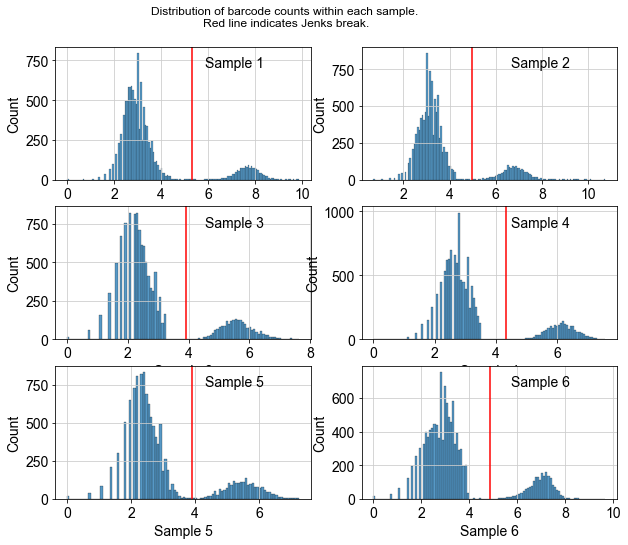

In [11]:
# Find breaks for low/high within each row.
# Use Fisher-Jenks breaks
# Package here..
import jenkspy

JBs = barcode_df.T.apply(lambda col : jenkspy.jenks_breaks(np.log1p(col), nb_class=2)).loc[1]
#

fig,ax = plt.subplots(3,2,figsize=(10,8))
for j in range(6):
    X = barcode_df.loc['Sample {}'.format(j+1)].copy()
    X = X.sort_values()
    curr_ax = ax[j//2, j%2]
    sns.histplot(np.log1p(X), ax=curr_ax)
    curr_ax.axvline(JBs['Sample {}'.format(j+1)], color='red')
    curr_ax.set_title('Sample {}'.format(j+1), y=0.8, x=0.7)
fig.suptitle('Distribution of barcode counts within each sample. \n'
            'Red line indicates Jenks break.')
plt.show()

JBs = np.exp(JBs) - 1 # exp-normalize Jenks breaks.

Each cell should only occur in one sample.  But maybe there are some tricky-to-call cells due to background.  We detect those below.

In [13]:
barcode_HL = (barcode_df.T >= JBs).T # Where is the barcode read above the sample background?
detected_samples = barcode_HL.sum() # In how many samples does the barcode count exceed the background?
detected_samples.value_counts()

1    11665
0       64
2       15
dtype: int64

In [14]:
easy_cells = detected_samples[detected_samples == 1].index
len(easy_cells)

11665

Now we assign cells to samples, using only the unambiguous ones.

In [15]:
cell_wells = barcode_HL[easy_cells].idxmax()
cell_wells.value_counts()

Sample 5    2178
Sample 3    2147
Sample 4    2143
Sample 6    1975
Sample 2    1701
Sample 1    1521
dtype: int64

In [16]:
cell_wells.head()

AAACCTGAGAAGGTGA-1    Sample 5
AAACCTGAGACAGGCT-1    Sample 2
AAACCTGAGCCCAATT-1    Sample 1
AAACCTGAGGACAGAA-1    Sample 6
AAACCTGCAGACACTT-1    Sample 4
dtype: object

## Loading the expression matrix.

It's big!  So we sparsify to get it down to 200MB or so in memory.  Take a look at the first few rows.

In [17]:
filename_EM = '20220815_JM_10x_1_CHfiltered_gex_matrix.csv'
EM_df = pd.read_csv(filename_EM, sep=',', nrows=5, index_col = 0)
EM_df

,AAACCTGAGAAGGTGA.1,AAACCTGAGACAGGCT.1,AAACCTGAGCCCAATT.1,AAACCTGAGGACAGAA.1,AAACCTGCAGACACTT.1,AAACCTGCAGTATGCT.1,AAACCTGCATAGACTC.1,AAACCTGCATTGGCGC.1,AAACCTGGTACGCACC.1,AAACCTGGTACTCTCC.1,...,TTTGTCAGTGAGGCTA.1,TTTGTCAGTTACGCGC.1,TTTGTCAGTTAGATGA.1,TTTGTCATCAAGGTAA.1,TTTGTCATCCAACCAA.1,TTTGTCATCGAATGGG.1,TTTGTCATCGTCACGG.1,TTTGTCATCTCCAGGG.1,TTTGTCATCTTCCTTC.1,TTTGTCATCTTGACGA.1
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
def load_chunks(filename, chunk_mem = 1e8, sep=',', sparsify=True, test_run = False, num_genes = 40000):
    df_head = pd.read_csv(filename, sep=sep, nrows=5, index_col = 0)
    usecols = [0] + list(range(1, len(df_head.columns)+1))
    
    dtype_dict = {j:np.uint32 for j in usecols} # Unsigned 32-bit integers to be safe.  4 bytes per entry.
    dtype_dict[0] = str
    
    mem_needed = 4 * len(usecols) * num_genes #65000 genes?  We will see!
    chunksize = chunk_mem // (4 * len(usecols))
    print('About {:,} bytes of memory needed for dataframe.'.format(mem_needed))
    print('Using {} chunks of {} genes, each needing {:,} bytes of memory.'.format(num_genes // chunksize,
                                                                                   chunksize, 
                                                                                   4*len(usecols)*chunksize))
    df_list = []
    j = 0
    if test_run:
        chunksize = 100
    print('Starting to load expression matrix now.  Please be patient.')
    for chunk in pd.read_csv(filename, sep=sep, index_col = 0, usecols=usecols, 
                             dtype=dtype_dict, chunksize=chunksize):
        j += 1
        print('{} genes loaded.'.format(j * chunksize))
        df = chunk
        if sparsify:
            old_mem = df.memory_usage().sum()
            df = df.astype(pd.SparseDtype(np.uint32, fill_value=0))
            new_mem = df.memory_usage().sum()
            print('Chunk sparsified from {:,} to {:,} bytes'.format(old_mem, new_mem))
        df_list.append(df)
        if test_run:
            if j > 3:
                return df_list
    return df_list

In [19]:
EM_df_list = load_chunks(filename_EM)

About 1,879,200,000 bytes of memory needed for dataframe.
Using 18.0 chunks of 2128.0 genes, each needing 99,973,440.0 bytes of memory.
Starting to load expression matrix now.  Please be patient.
2128.0 genes loaded.
Chunk sparsified from 99,981,952 to 14,022,368 bytes
4256.0 genes loaded.
Chunk sparsified from 99,981,952 to 12,076,776 bytes
6384.0 genes loaded.
Chunk sparsified from 99,981,952 to 12,400,512 bytes
8512.0 genes loaded.
Chunk sparsified from 99,981,952 to 11,453,696 bytes
10640.0 genes loaded.
Chunk sparsified from 99,981,952 to 10,133,904 bytes
12768.0 genes loaded.
Chunk sparsified from 99,981,952 to 13,461,408 bytes
14896.0 genes loaded.
Chunk sparsified from 99,981,952 to 10,871,568 bytes
17024.0 genes loaded.
Chunk sparsified from 99,981,952 to 10,023,496 bytes
19152.0 genes loaded.
Chunk sparsified from 99,981,952 to 11,805,584 bytes
21280.0 genes loaded.
Chunk sparsified from 99,981,952 to 13,387,944 bytes
23408.0 genes loaded.
Chunk sparsified from 99,981,952 to 

In [20]:
EM_df = pd.concat(EM_df_list)
EM_mem = EM_df.memory_usage().sum()
print('{:,} bytes of memory used in expression matrix.'.format(EM_mem))

206,725,384 bytes of memory used in expression matrix.


In [21]:
EM_df.head()

,AAACCTGAGAAGGTGA.1,AAACCTGAGACAGGCT.1,AAACCTGAGCCCAATT.1,AAACCTGAGGACAGAA.1,AAACCTGCAGACACTT.1,AAACCTGCAGTATGCT.1,AAACCTGCATAGACTC.1,AAACCTGCATTGGCGC.1,AAACCTGGTACGCACC.1,AAACCTGGTACTCTCC.1,...,TTTGTCAGTGAGGCTA.1,TTTGTCAGTTACGCGC.1,TTTGTCAGTTAGATGA.1,TTTGTCATCAAGGTAA.1,TTTGTCATCCAACCAA.1,TTTGTCATCGAATGGG.1,TTTGTCATCGTCACGG.1,TTTGTCATCTCCAGGG.1,TTTGTCATCTTCCTTC.1,TTTGTCATCTTGACGA.1
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
EM_df.columns = [cell.replace('.','-') for cell in EM_df.columns] # Change dot to dash.
EM_df.head()

,AAACCTGAGAAGGTGA-1,AAACCTGAGACAGGCT-1,AAACCTGAGCCCAATT-1,AAACCTGAGGACAGAA-1,AAACCTGCAGACACTT-1,AAACCTGCAGTATGCT-1,AAACCTGCATAGACTC-1,AAACCTGCATTGGCGC-1,AAACCTGGTACGCACC-1,AAACCTGGTACTCTCC-1,...,TTTGTCAGTGAGGCTA-1,TTTGTCAGTTACGCGC-1,TTTGTCAGTTAGATGA-1,TTTGTCATCAAGGTAA-1,TTTGTCATCCAACCAA-1,TTTGTCATCGAATGGG-1,TTTGTCATCGTCACGG-1,TTTGTCATCTCCAGGG-1,TTTGTCATCTTCCTTC-1,TTTGTCATCTTGACGA-1
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
gene_total_counts = EM_df.sum(axis=1)
genes_expressed = gene_total_counts[gene_total_counts > 0].index
EM_df = EM_df.loc[genes_expressed]
EM_df

,AAACCTGAGAAGGTGA-1,AAACCTGAGACAGGCT-1,AAACCTGAGCCCAATT-1,AAACCTGAGGACAGAA-1,AAACCTGCAGACACTT-1,AAACCTGCAGTATGCT-1,AAACCTGCATAGACTC-1,AAACCTGCATTGGCGC-1,AAACCTGGTACGCACC-1,AAACCTGGTACTCTCC-1,...,TTTGTCAGTGAGGCTA-1,TTTGTCAGTTACGCGC-1,TTTGTCAGTTAGATGA-1,TTTGTCATCAAGGTAA-1,TTTGTCATCCAACCAA-1,TTTGTCATCGAATGGG-1,TTTGTCATCGTCACGG-1,TTTGTCATCTCCAGGG-1,TTTGTCATCTTCCTTC-1,TTTGTCATCTTGACGA-1
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC01409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM87B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC004556.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC233755.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC136612.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
EM_df = EM_df[easy_cells]
EM_df.shape # (num genes, num cells)

(23710, 11665)

## Loading TCR metadata

Here we load metadata on the cells, with lots of TCR data.

In [25]:
filename_annot = 'filtered_contig_annotations.csv'
annot_df = pd.read_csv(filename_annot, index_col=0)
annot_df.head()

,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,...,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACAGGCT-1,True,AAACCTGAGACAGGCT-1_contig_1,True,492,TRA,TRAV9-2,NaN,TRAJ45,TRAC,True,...,GGAAGCAACAAAGGTTTTGAAGCCACATACCGTAAAGAAACCACTT...,CALRGGGADGLTF,TGTGCTCTGAGAGGAGGAGGTGCTGACGGACTCACCTTT,GKGTHLIIQP,GGCAAAGGGACTCATCTAATCATCCAGCCCT,2310,25,clonotype2,clonotype2_consensus_2,1
AAACCTGAGACAGGCT-1,True,AAACCTGAGACAGGCT-1_contig_2,True,656,TRB,TRBV5-4,TRBD2,TRBJ2-4,TRBC2,True,...,AATGGCAGAGGAAACTTCCCTCCTAGATTCTCAGGTCTCCAGTTCC...,CASSFGLAGVGDIQYF,TGTGCCAGCAGCTTCGGACTAGCGGGTGTGGGGGACATTCAGTACTTC,GAGTRLSVL,GGCGCCGGGACCCGGCTCTCAGTGCTGG,932,23,clonotype2,clonotype2_consensus_1,1
AAACCTGCAACAACCT-1,True,AAACCTGCAACAACCT-1_contig_1,True,551,TRA,TRAV26-2,NaN,TRAJ57,TRAC,True,...,GTGAACAACAGAATGGCCTCTCTGGCAATCGCTGAAGACAGAAAGT...,CILRGIKGQGGSEKLVF,TGCATCCTGAGAGGGATAAAAGGACAGGGCGGATCTGAAAAGCTGG...,GKGTKLTVNP,GGAAAGGGAACGAAACTGACAGTAAACCCAT,2372,32,clonotype1,clonotype1_consensus_2,1
AAACCTGCAACAACCT-1,True,AAACCTGCAACAACCT-1_contig_2,True,521,TRB,TRBV6-2,NaN,TRBJ1-5,TRBC1,True,...,ACTGCCAAAGGAGAGGTCCCTGATGGCTACAATGTCTCCAGATTAA...,CASRDQGGVRDQPQHF,TGTGCCAGCAGGGATCAGGGAGGCGTTAGAGATCAGCCCCAGCATTTT,GDGTRLSIL,GGTGATGGGACTCGACTCTCCATCCTAG,1796,24,clonotype1,clonotype1_consensus_1,1
AAACCTGCAATTGCTG-1,True,AAACCTGCAATTGCTG-1_contig_1,True,492,TRA,TRAV9-2,NaN,TRAJ45,TRAC,True,...,GGAAGCAACAAAGGTTTTGAAGCCACATACCGTAAAGAAACCACTT...,CALRGGGADGLTF,TGTGCTCTGAGAGGAGGAGGTGCTGACGGACTCACCTTT,GKGTHLIIQP,GGCAAAGGGACTCATCTAATCATCCAGCCCT,2898,27,clonotype2,clonotype2_consensus_2,1


In [26]:
annot_df.shape

(26222, 30)

In [27]:
annot_df.is_cell.value_counts() # Hope everything is a cell!

True    26222
Name: is_cell, dtype: int64

In [28]:
annot_df.high_confidence.value_counts() # Hope we're confident!

True    26222
Name: high_confidence, dtype: int64

In [29]:
annot_df.columns # What's in here?

Index(['is_cell', 'contig_id', 'high_confidence', 'length', 'chain', 'v_gene',
       'd_gene', 'j_gene', 'c_gene', 'full_length', 'productive', 'fwr1',
       'fwr1_nt', 'cdr1', 'cdr1_nt', 'fwr2', 'fwr2_nt', 'cdr2', 'cdr2_nt',
       'fwr3', 'fwr3_nt', 'cdr3', 'cdr3_nt', 'fwr4', 'fwr4_nt', 'reads',
       'umis', 'raw_clonotype_id', 'raw_consensus_id',
       'exact_subclonotype_id'],
      dtype='object')

We look for barcodes with more than one TRA or TRB pattern appearing.  These can indicate doublets.  First we count the number of TRA and TRBs occurring for each barcode.

In [30]:
TR_counts = annot_df.groupby('barcode')['chain'].value_counts().sort_values()
TR_counts

barcode             chain
AAACCTGAGACAGGCT-1  TRA      1
GGAACTTTCCTGCCAT-1  TRB      1
GGAACTTTCCCTTGCA-1  TRB      1
                    TRA      1
GGAACTTTCCCTGACT-1  TRB      1
                            ..
TACCTATCAGCTGTGC-1  TRA      2
CGGACTGCATCTCCCA-1  TRA      2
GACGCGTAGACTTGAA-1  TRA      2
GGAGCAACACCGATAT-1  TRA      2
CATCGAATCCTAGAAC-1  TRB      2
Name: chain, Length: 24508, dtype: int64

In [31]:
doublets = TR_counts[TR_counts >= 2].index.get_level_values(0).unique()
doublets

Index(['TTAGGCACACACAGAG-1', 'AAGTCTGAGTTGCAGG-1', 'CAGATCATCAGTTAGC-1',
       'CAGAATCTCGCCCTTA-1', 'TTAGTTCTCAATCTCT-1', 'GTATCTTGTACATGTC-1',
       'CACACAACAGATCCAT-1', 'CTGATAGTCTATCCCG-1', 'CGTTCTGAGCCAACAG-1',
       'CACACCTCAGGGCATA-1',
       ...
       'CGGACTGCAGTCCTTC-1', 'TGCGCAGTCCCTAATT-1', 'GACGCGTAGGAATGGA-1',
       'TGCGCAGTCTATCGCC-1', 'CATGCCTAGACCGGAT-1', 'TACCTATCAGCTGTGC-1',
       'CGGACTGCATCTCCCA-1', 'GACGCGTAGACTTGAA-1', 'GGAGCAACACCGATAT-1',
       'CATCGAATCCTAGAAC-1'],
      dtype='object', name='barcode', length=1708)

In [34]:
single_cells = [cell for cell in EM_df.columns if cell not in doublets]
len(single_cells)

10303

In [35]:
single_cells = [cell for cell in single_cells if cell in annot_df.index]
len(single_cells)

8673

In [36]:
clonotypes = annot_df.loc[single_cells, 'raw_clonotype_id']
clonotypes

barcode
AAACCTGAGACAGGCT-1     clonotype2
AAACCTGAGACAGGCT-1     clonotype2
AAACCTGCAGACACTT-1     clonotype6
AAACCTGCAGACACTT-1     clonotype6
AAACCTGCAGTATGCT-1    clonotype19
                         ...     
TTTGTCATCTCCAGGG-1     clonotype1
TTTGTCATCTTCCTTC-1     clonotype2
TTTGTCATCTTCCTTC-1     clonotype2
TTTGTCATCTTGACGA-1     clonotype3
TTTGTCATCTTGACGA-1     clonotype3
Name: raw_clonotype_id, Length: 16516, dtype: object

In [38]:
clonotypes = clonotypes.groupby('barcode').first()
clonotypes

barcode
AAACCTGAGACAGGCT-1      clonotype2
AAACCTGCAGACACTT-1      clonotype6
AAACCTGCAGTATGCT-1     clonotype19
AAACCTGCATTGGCGC-1      clonotype2
AAACCTGGTACGCACC-1      clonotype8
                          ...     
TTTGTCATCGAATGGG-1      clonotype2
TTTGTCATCGTCACGG-1    clonotype107
TTTGTCATCTCCAGGG-1      clonotype1
TTTGTCATCTTCCTTC-1      clonotype2
TTTGTCATCTTGACGA-1      clonotype3
Name: raw_clonotype_id, Length: 8673, dtype: object

In [39]:
clonotypes.value_counts()

clonotype1      1382
clonotype3       897
clonotype2       884
clonotype6       460
clonotype5       453
                ... 
clonotype77        1
clonotype129       1
clonotype109       1
clonotype73        1
clonotype142       1
Name: raw_clonotype_id, Length: 124, dtype: int64

# Assembling a loom file

In [79]:
adata = sc.AnnData(EM_df[single_cells].T) # Only take single cells

In [80]:
adata.to_df()

,AL627309.1,AL627309.5,AP006222.2,LINC01409,FAM87B,LINC01128,LINC00115,SAMD11,NOC2L,KLHL17,...,AC011043.2,AC011841.1,AL354822.1,AL592183.1,AC240274.1,AC004556.3,AC233755.1,AC136612.1,AC007325.4,AC007325.2
AAACCTGAGACAGGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCAGACACTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCAGTATGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCATTGGCGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGGTACGCACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGAATGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCATCGTCACGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCATCTCCAGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCATCTTCCTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
adata.obs['clonotype'] = clonotypes
adata.obs['sample'] = cell_wells
adata.obs

,clonotype,sample
AAACCTGAGACAGGCT-1,clonotype2,Sample 2
AAACCTGCAGACACTT-1,clonotype6,Sample 4
AAACCTGCAGTATGCT-1,clonotype19,Sample 6
AAACCTGCATTGGCGC-1,clonotype2,Sample 2
AAACCTGGTACGCACC-1,clonotype8,Sample 4
...,...,...
TTTGTCATCGAATGGG-1,clonotype2,Sample 2
TTTGTCATCGTCACGG-1,clonotype107,Sample 3
TTTGTCATCTCCAGGG-1,clonotype1,Sample 5
TTTGTCATCTTCCTTC-1,clonotype2,Sample 2


# Preprocessing...

In [82]:
sc.pp.highly_variable_genes(adata, n_top_genes=7500, flavor='seurat_v3')

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [83]:
umi_totals = adata.to_df().sum(axis=1)
umi_totals.groupby(adata.obs['sample']).mean()

sample
Sample 1    5471.356934
Sample 2    6266.974121
Sample 3    4675.565918
Sample 4    4895.136230
Sample 5    7078.302734
Sample 6    4809.293457
dtype: float32

In [84]:
sc.pp.normalize_total(adata, target_sum = 10000, exclude_highly_expressed=True) #Normalize 

In [85]:
umi_totals = adata.to_df().sum(axis=1)
umi_totals.groupby(adata.obs['sample']).mean()

sample
Sample 1    10378.183594
Sample 2    10439.939453
Sample 3    10410.616211
Sample 4    10455.672852
Sample 5    10517.099609
Sample 6    10413.471680
dtype: float32

In [86]:
genes_before = adata.n_vars
sc.pp.filter_genes(adata, min_counts=1) # At least 1 count.
genes_after = adata.n_vars
print('Dataset has {} genes before and {} after filtering never-expressed.'.format(genes_before,genes_after))

Dataset has 23710 genes before and 22664 after filtering never-expressed.


In [87]:
sc.pp.log1p(adata) #pseudo-log transform

In [88]:
print('Summary of AnnData object for (shape = #samples x #genes)')
print(adata)

Summary of AnnData object for (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 8673 × 22664
    obs: 'clonotype', 'sample'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts'
    uns: 'hvg', 'log1p'


In [89]:
def drop_TRs(ad, filename='TR_gene_data.csv'):
    ad_out = ad
    TR_gene_df = pd.read_csv(filename, index_col=0)
    TR_genes = TR_gene_df['gene_name'].values
    bad_genes = [gene for gene in ad_out.var_names if gene in TR_genes]
    print('{} genes removed.'.format(len(bad_genes)))
    keep_genes = [gene for gene in ad_out.var_names if not gene in bad_genes]
    ad_out = ad_out[:, keep_genes]
    return ad_out

In [90]:
adata = drop_TRs(adata)

201 genes removed.


In [91]:
adata

View of AnnData object with n_obs × n_vars = 8673 × 22463
    obs: 'clonotype', 'sample'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts'
    uns: 'hvg', 'log1p'

## Quality control

## Highest expressed genes

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


<AxesSubplot:xlabel='% of total counts'>

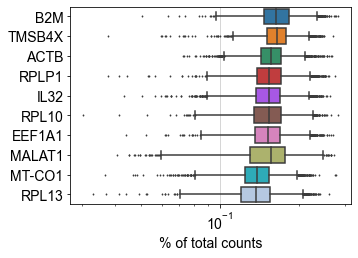

In [92]:
sc.pl.highest_expr_genes(adata, n_top=10, log=True, show=False)

## Compute quality control metrics

In [93]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

## Separate by sample

In [103]:
adata.obs['sample'].value_counts()

Sample 5    1850
Sample 4    1749
Sample 3    1597
Sample 2    1439
Sample 6    1094
Sample 1     944
Name: sample, dtype: int64

In [98]:
samples = ['Sample {}'.format(j) for j in range(1,7)]
samples

['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample 6']

In [96]:
ads = {}
for samp in samples:
    ads[samp] = adata[adata.obs['sample'] == samp]
    sc.pp.calculate_qc_metrics(ads[samp], qc_vars=['mt'], percent_top=None, inplace=True)
    print(ads[samp])


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1439 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 1749 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 1

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1850 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 944 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 15

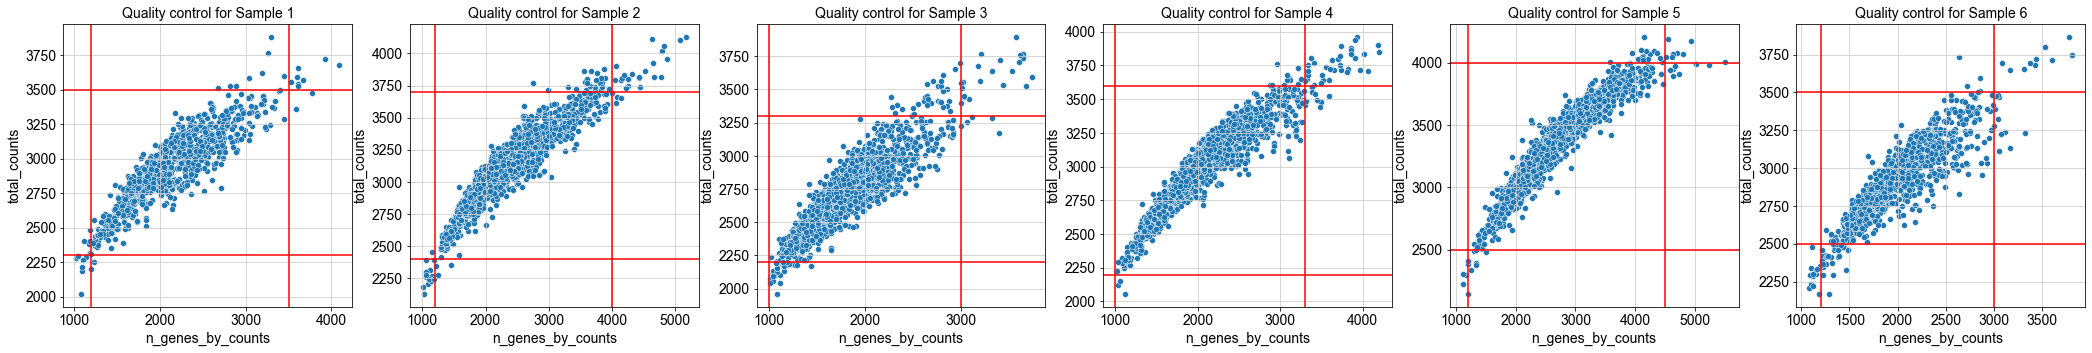

In [100]:
fig,ax = plt.subplots(1,len(samples), figsize=(len(samples)*6,5))

min_counts = {'Sample 1': 2300,
              'Sample 2': 2400,
              'Sample 3': 2200,
              'Sample 4': 2200,
              'Sample 5': 2500,
              'Sample 6' : 2500}

max_counts = {'Sample 1': 3500,
              'Sample 2': 3700,
              'Sample 3': 3300,
              'Sample 4': 3600,
              'Sample 5': 4000,
              'Sample 6' : 3500}

min_genes = {'Sample 1': 1200,
              'Sample 2': 1200,
              'Sample 3': 1000,
              'Sample 4': 1000,
              'Sample 5': 1200,
              'Sample 6' : 1200}

max_genes = {'Sample 1': 3500,
              'Sample 2': 4000,
              'Sample 3': 3000,
              'Sample 4': 3300,
              'Sample 5': 4500,
              'Sample 6' : 3000}
                                               
                                
for j,samp in enumerate(samples):
    sns.scatterplot(x='n_genes_by_counts', y='total_counts', 
                    data=ads[samp].obs,  ax=ax[j])
    ax[j].set_title('Quality control for {}'.format(samp))   
    ax[j].axhline(min_counts[samp], color='red')
    ax[j].axhline(max_counts[samp], color='red')
    ax[j].axvline(min_genes[samp], color='red')
    ax[j].axvline(max_genes[samp], color='red')

In [101]:
for samp in samples:
    sc.pp.filter_cells(ads[samp], min_counts=min_counts[samp])
    sc.pp.filter_cells(ads[samp], max_counts=max_counts[samp])
    sc.pp.filter_cells(ads[samp], min_genes=min_genes[samp])
    sc.pp.filter_cells(ads[samp], max_genes=max_genes[samp])

In [102]:
for samp in samples:
    print(ads[samp])

AnnData object with n_obs × n_vars = 910 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 1372 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', '

# Save data!

In [106]:
for samp in samples:
    filename = 'Processed/Data10x_'+samp+'.loom'
    ads[samp].write_loom(filename)
    print('Data written to {}'.format(filename))

Data written to Processed/Data10x_Sample 1.loom
Data written to Processed/Data10x_Sample 2.loom
Data written to Processed/Data10x_Sample 3.loom
Data written to Processed/Data10x_Sample 4.loom
Data written to Processed/Data10x_Sample 5.loom
Data written to Processed/Data10x_Sample 6.loom


# Explorations

In [274]:
big_clones = {}
ad_big = {}
for samp in samples:
    cs = ads[samp].obs.clonotype.value_counts().sort_values()
    big_clones[samp] = cs[cs >= 30].index
    bc_cells = ads[samp].obs.clonotype.isin(big_clones[samp])
    bc_cells = bc_cells[bc_cells].index
    print('{} clones with at least 30 cells in {}.  Total {} cells'.format(len(big_clones[samp]), 
                                                                           samp, len(bc_cells)))
    
    ad_big[samp] = ads[samp][bc_cells]

4 clones with at least 30 cells in Sample 1.  Total 841 cells
6 clones with at least 30 cells in Sample 2.  Total 1358 cells
6 clones with at least 30 cells in Sample 3.  Total 1477 cells
6 clones with at least 30 cells in Sample 4.  Total 1660 cells
3 clones with at least 30 cells in Sample 5.  Total 1758 cells
6 clones with at least 30 cells in Sample 6.  Total 1008 cells


In [275]:
for samp in samples:
    sc.tl.pca(ad_big[samp], svd_solver='arpack')

In [276]:
for samp in samples:
    sc.pp.neighbors(ad_big[samp], n_neighbors=10, n_pcs=40)

In [277]:
for samp in samples:
    sc.tl.umap(ad_big[samp])

... storing 'clonotype' as categorical
... storing 'sample' as categorical


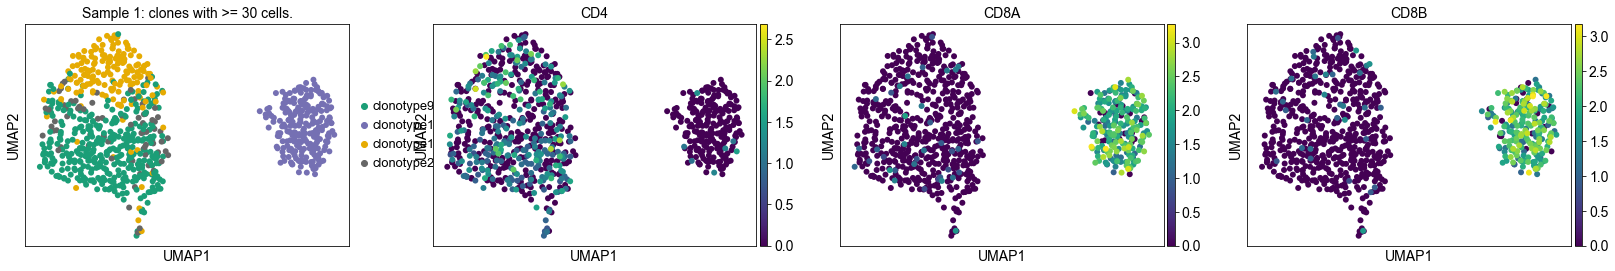

... storing 'clonotype' as categorical
... storing 'sample' as categorical


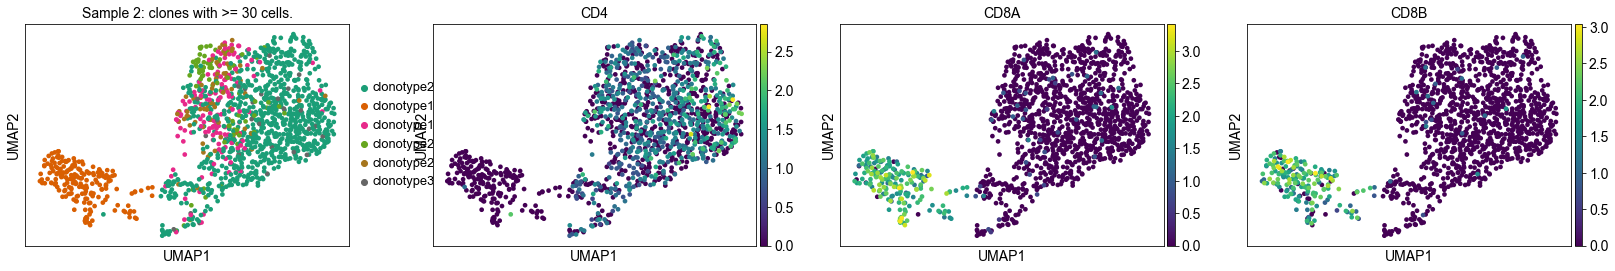

... storing 'clonotype' as categorical
... storing 'sample' as categorical


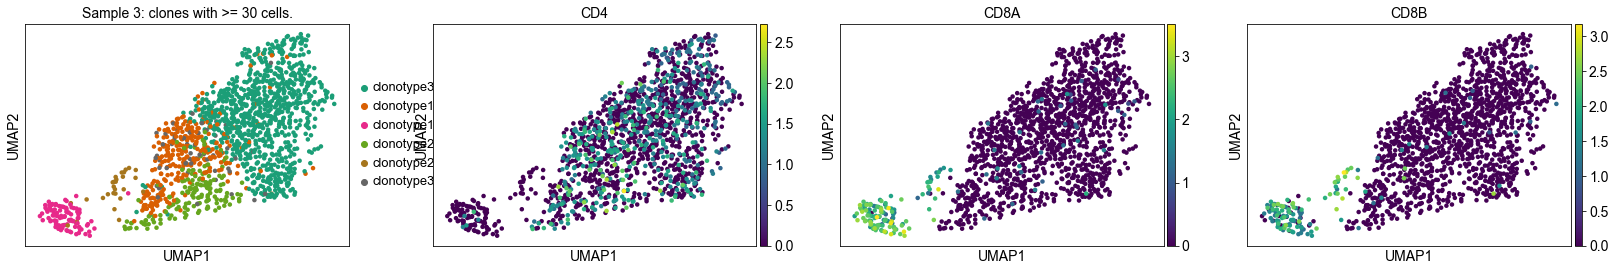

... storing 'clonotype' as categorical
... storing 'sample' as categorical


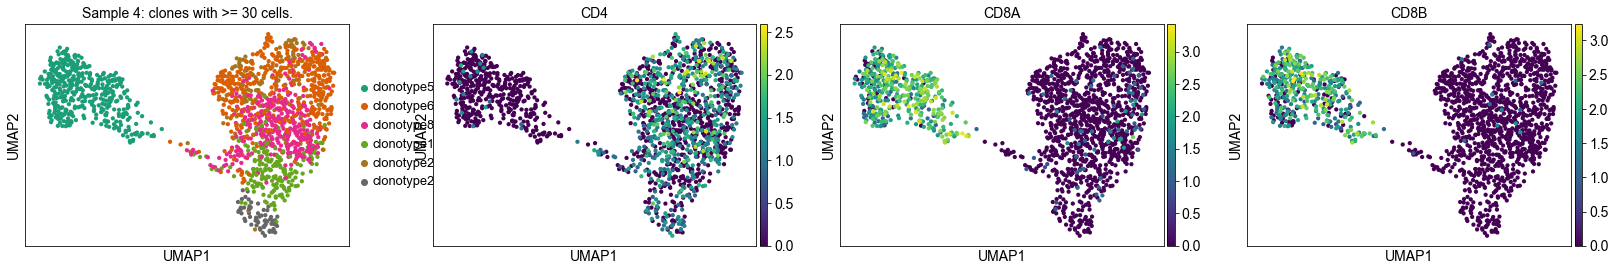

... storing 'clonotype' as categorical
... storing 'sample' as categorical


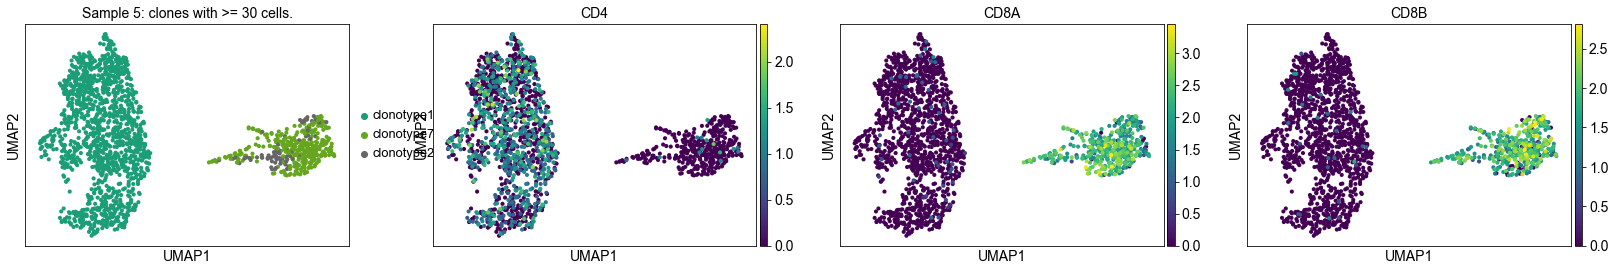

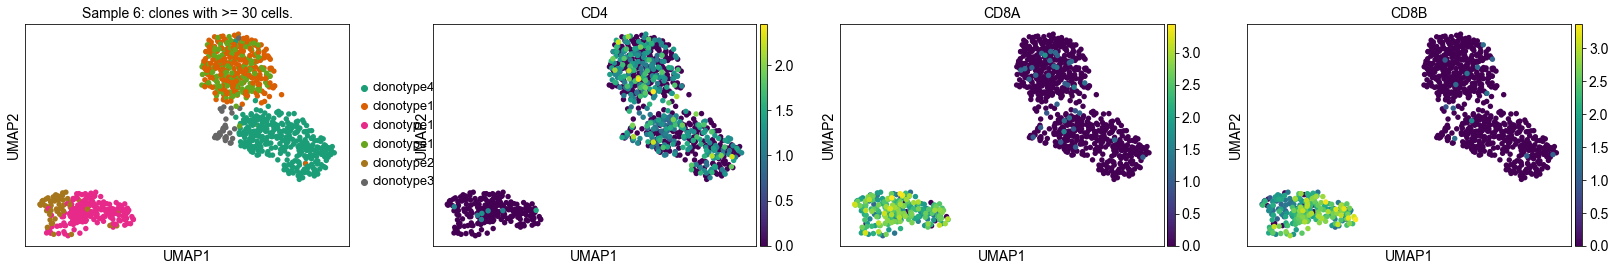

In [278]:
for samp in samples:
    sc.pl.umap(ad_big[samp], color=['clonotype','CD4','CD8A', 'CD8B'], palette='Dark2',
              title='{}: clones with >= 30 cells.'.format(samp))

# Separate CD4 and CD8 populations

The CD4 and CD8 cells are pretty easy to see in the UMAP plot.  Here we use the average CD4 and CD8A and CD8B within each clonotype to declare cells to be CD4 or CD8 T-cells.  Note that all cells belonging to a clone will be the same type here.  

In [279]:
def CD_type(ad,verbose=False):
    CD_df = ad.to_df()[['CD8A','CD8B','CD4']]
    CD_df['clonotype'] = ad.obs.clonotype
    clone_CD = CD_df.groupby('clonotype').mean()
    breaks = 0.5*(clone_CD.max() + clone_CD.min())
    clone_HL = (clone_CD > breaks).astype(int)
    calls_CD = (clone_HL['CD8A']+clone_HL['CD8B'] + 1 - clone_HL['CD4']).map({0:'CD4_type', 3:'CD8_type'})
    clone_CD['Tcell_type'] = calls_CD
    if verbose:
        display(clone_CD)
    return calls_CD

In [280]:
for samp in samples:
    CD_types = CD_type(ad_big[samp])
    ad_big[samp].obs['CD_type'] = ad_big[samp].obs.clonotype.map(CD_types)
    ad_big[samp].obs

... storing 'CD_type' as categorical


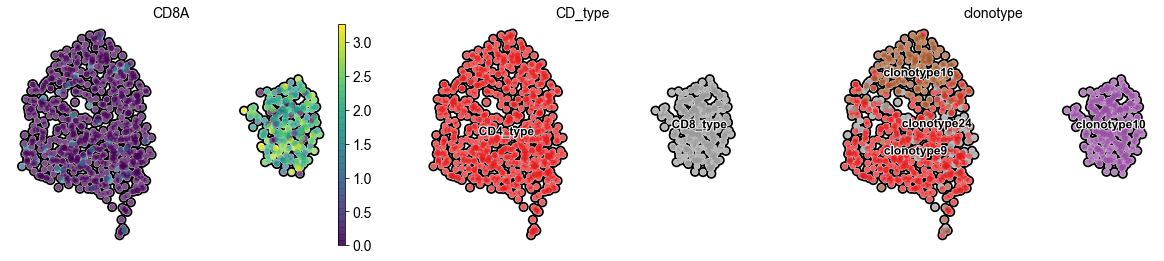

... storing 'CD_type' as categorical


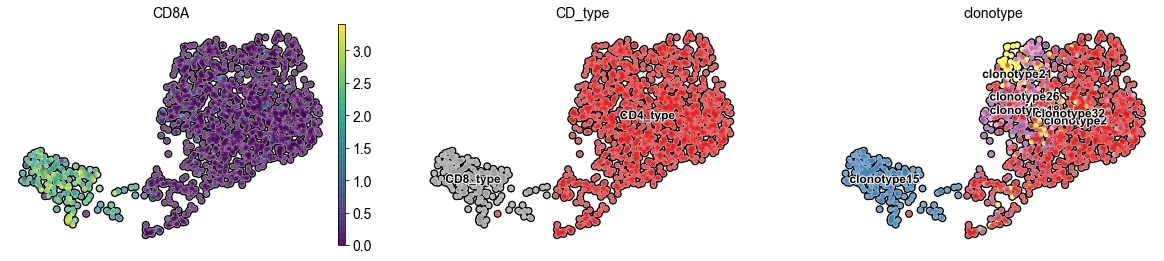

... storing 'CD_type' as categorical


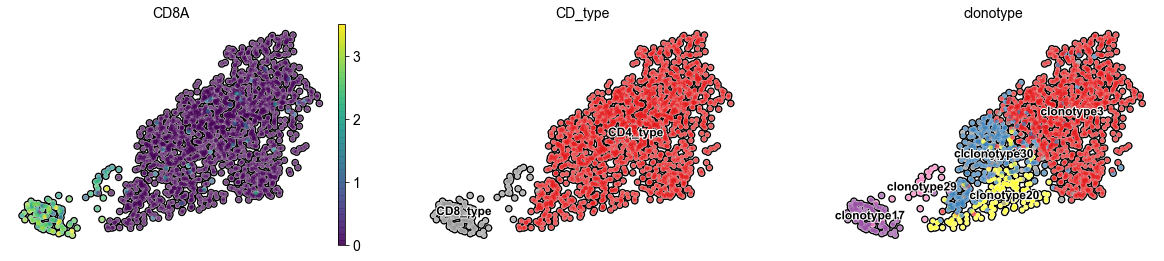

... storing 'CD_type' as categorical


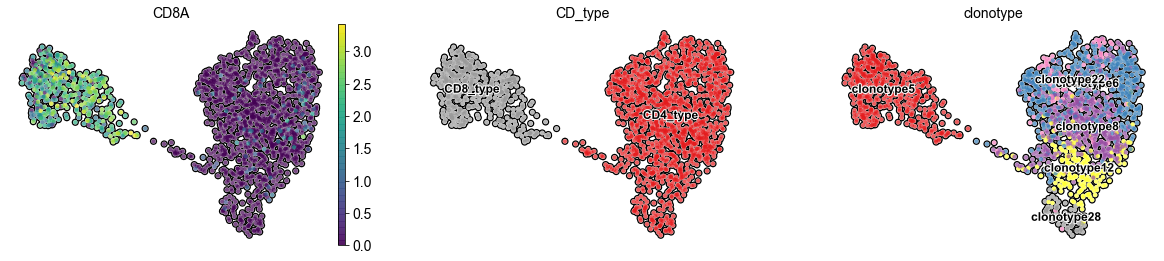

... storing 'CD_type' as categorical


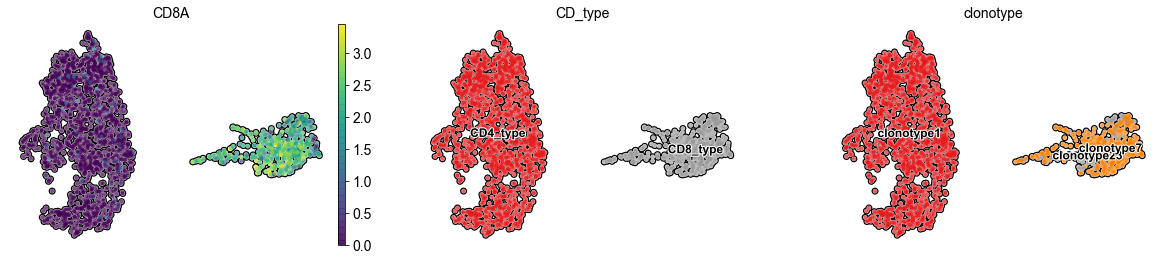

... storing 'CD_type' as categorical


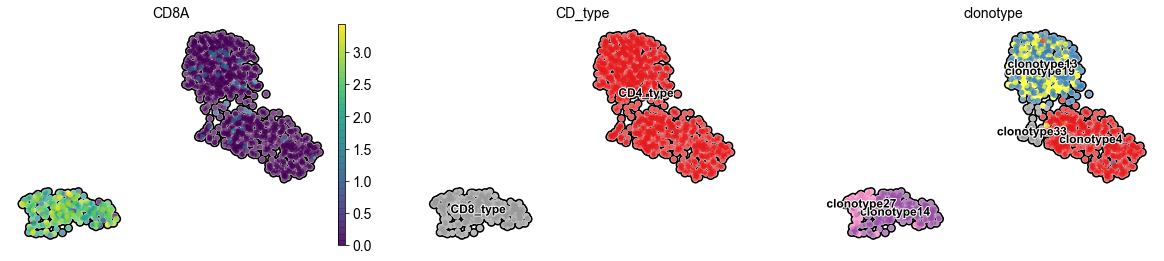

In [281]:
for samp in samples:
    sc.pl.umap(ad_big[samp], color=['CD8A','CD_type','clonotype'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title=['CD8A','CD_type','clonotype'], palette='Set1')

In [282]:
for samp in samples:
    samp_name = samp.replace(' ','_')
    filename = 'Processed/Big_clones_'+samp_name+'.loom'
    ad_big[samp].write_loom(filename)
    print('Data written to {}'.format(filename))

The loom file will lack these fields:
{'PCs', 'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations
The loom file will lack these fields:
{'PCs', 'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations


Data written to Processed/Big_clones_Sample_1.loom


The loom file will lack these fields:
{'PCs', 'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations


Data written to Processed/Big_clones_Sample_2.loom


The loom file will lack these fields:
{'PCs', 'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations


Data written to Processed/Big_clones_Sample_3.loom


The loom file will lack these fields:
{'PCs', 'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations


Data written to Processed/Big_clones_Sample_4.loom


The loom file will lack these fields:
{'PCs', 'X_umap', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations


Data written to Processed/Big_clones_Sample_5.loom
Data written to Processed/Big_clones_Sample_6.loom


In [283]:
ad_big[samp]

AnnData object with n_obs × n_vars = 1008 × 22463
    obs: 'clonotype', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'CD_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'clonotype_colors', 'CD_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'